In [ ]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from collections import Counter
import zipfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import random
from torch import nn, optim
import math
from collections import defaultdict, deque
import datetime
import time
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from torchvision.transforms import v2 as _T
from torchvision import datasets
from torch.utils.data import Dataset, sampler, random_split, DataLoader
import torch
import cv2
from torchvision import transforms
import torchvision
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import functional as F
from torchvision.transforms.v2 import functional as _F
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import copy
from torch.optim.lr_scheduler import StepLR


from google.colab import drive

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Extract files from .zip
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AAI_541_Capstone/Dataset_edit.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


In [ ]:
# Get dataset path
dataset_dir = os.path.join('/content/Dataset_edit', 'dataset')

In [ ]:
# Load the COCO annotations
annotations_path = os.path.join(dataset_dir, '_annotations.coco.json')
with open(annotations_path, 'r') as f:
    coco_data = json.load(f)

# Inspect the keys in the loaded annotations
coco_data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

# Exploratory Data Analysis (EDA)

In [ ]:
# Check to see the number of color vs X-ray (grayscale) images within the dataset
def is_grayscale_rgb(image):
    r, g, b = image.split()
    if not (np.array_equal(np.array(r), np.array(g)) and np.array_equal(np.array(r), np.array(b))):
        return False
    return True

# Initialize counts
color_count = 0
grayscale_count = 0

# Iterate through all images in the dataset directory
for image_filename in os.listdir(dataset_dir):
    image_path = os.path.join(dataset_dir, image_filename)

    try:
        with Image.open(image_path) as img:
            # If the image is in RGB format but essentially grayscale
            if img.mode == 'RGB' and is_grayscale_rgb(img):
                grayscale_count += 1
            # If the image is explicitly grayscale
            elif img.mode == 'L':
                grayscale_count += 1
            # If the image is color
            else:
                color_count += 1
    except Exception as e:
        print(f"Error processing image {image_filename}: {e}")

print('Color images: ', color_count)
print('X-ray images: ', grayscale_count)


Error processing image _annotations.coco.json: cannot identify image file '/content/Dataset_edit/dataset/_annotations.coco.json'
Color images:  445
X-ray images:  595


In [ ]:
# View the label classes
coco_data['categories']

[{'id': 0, 'name': 'dental', 'supercategory': 'none'},
 {'id': 1, 'name': 'cavity', 'supercategory': 'dental'},
 {'id': 2, 'name': 'pockets', 'supercategory': 'dental'},
 {'id': 3, 'name': 'tooth', 'supercategory': 'dental'}]

### Count the number of bounding boxes for each label class

In [ ]:
# Get the counts of bounding boxes for each category class:

# Extract categories and annotations
categories = {category['id']: category['name'] for category in coco_data['categories']}
annotations = coco_data['annotations']

# Initialize dictionary to store counts
category_counts = {category: 0 for category in categories.values()}

# Count the annotations in each category class
for annotation in annotations:
    category_id = annotation['category_id']
    category_name = categories[category_id]
    category_counts[category_name] += 1

category_counts


{'dental': 0, 'cavity': 2221, 'pockets': 450, 'tooth': 2119}

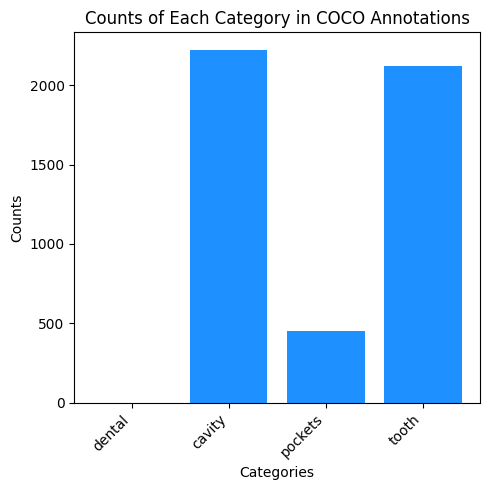

In [ ]:
# Visualize these counts:

# Separate categories and their counts
categories_ = list(category_counts.keys())
counts_ = list(category_counts.values())

# Plot the chart
plt.figure(figsize=(5, 5))  # adjust the figure size
plt.bar(categories_, counts_, color='dodgerblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Each Category in COCO Annotations')
plt.xticks(rotation=45, ha='right')  # Rotate category names for better visibility
plt.tight_layout()

plt.show()


#### Aside from the empty 'dental' label, cavity has the largest count.

### Visualize a few images and their bounding boxes

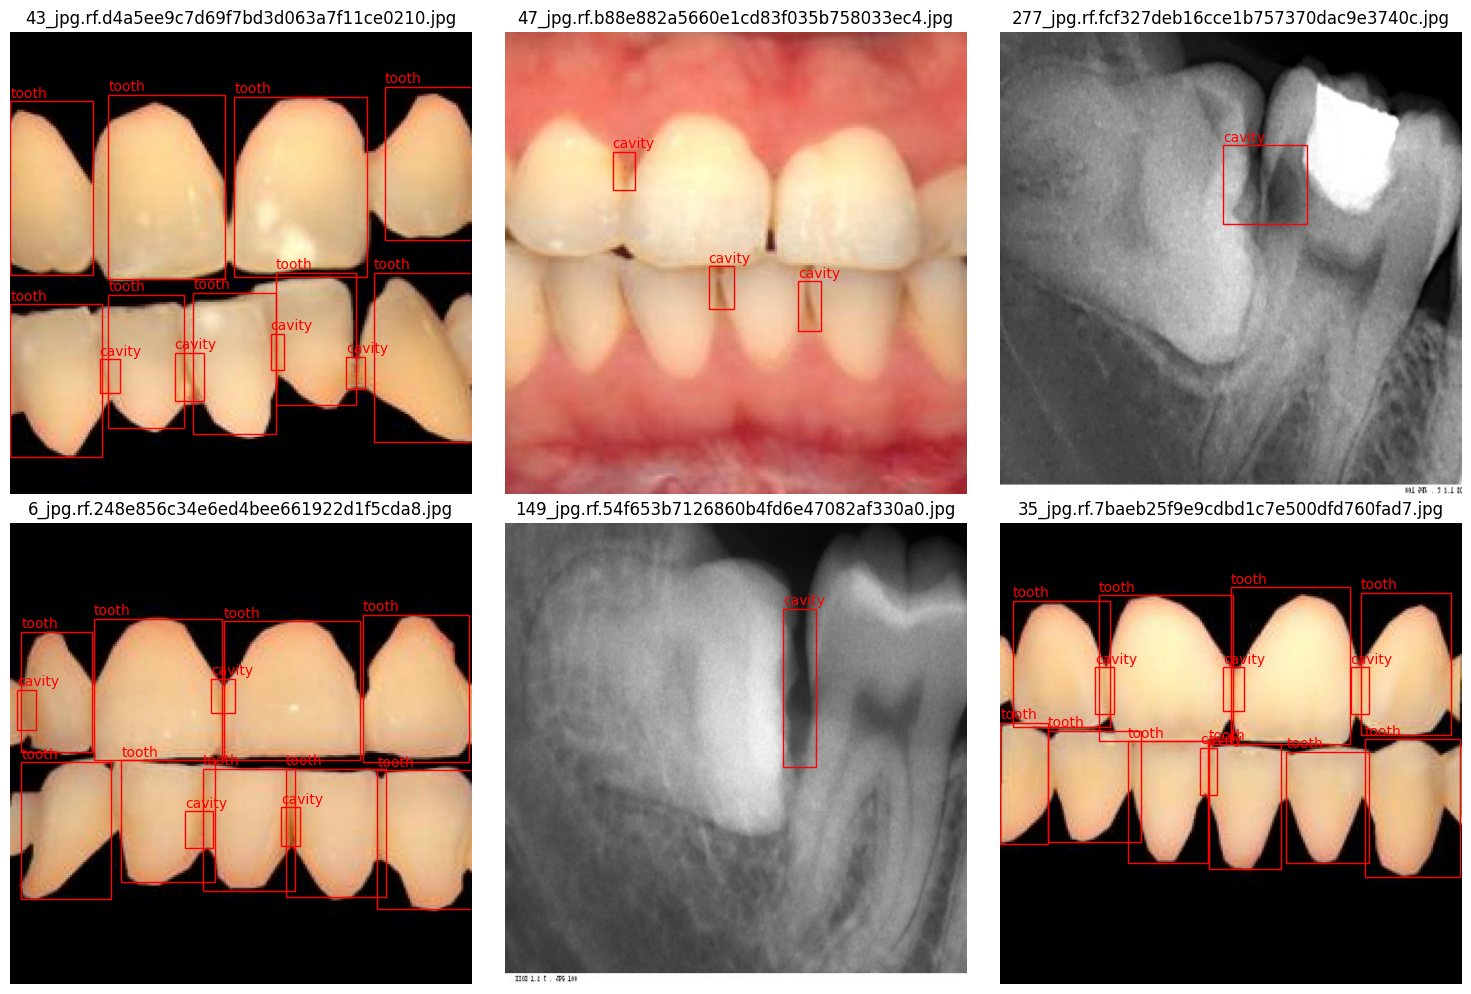

In [ ]:
# Retrieve the category name based on the category ID.
def get_category_name(category_id, categories):
    for category in categories:
        if category['id'] == category_id:
            return category['name']
    return "Unknown"

# Plot randomly selected images with bounding boxes and their category names
def plot_random_images_with_bboxes_and_category(images_list, annotations_list, categories_list, base_path, ax):
    """."""
    selected_images = random.sample(images_list, 6)  # Randomly select 6 images

    for idx, image in enumerate(selected_images):
        image_path = os.path.join(base_path, image['file_name'])
        im = Image.open(image_path)
        ax[idx].imshow(im)

        # Getting the annotations for the current image
        img_annotations = [ann for ann in annotations_list if ann['image_id'] == image['id']]

        for ann in img_annotations:
            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            ax[idx].add_patch(rect)

            # Getting category name
            category_name = get_category_name(ann['category_id'], categories_list)
            ax[idx].text(bbox[0], bbox[1]-5, category_name, color='r', fontsize=10)

        ax[idx].axis('off')
        ax[idx].set_title(image['file_name'])

# Visualize:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plot_random_images_with_bboxes_and_category(coco_data['images'], coco_data['annotations'], coco_data['categories'], dataset_dir, ax)
plt.tight_layout()
plt.show()



### Determine if any images do not contain bounding boxes.

In [ ]:
# Extract all image IDs that have bounding box data from the annotations list
image_ids_with_bboxes = set([annotation['image_id'] for annotation in coco_data['annotations']])

# Find images that don't have bounding box data
images_without_bboxes = [image for image in coco_data['images'] if image['id'] not in image_ids_with_bboxes]

# Extract filenames of images without bounding boxes for clearer reference
filenames_without_bboxes = [image['file_name'] for image in images_without_bboxes]

# Count of images without bounding box data
count_images_without_bboxes = len(images_without_bboxes)
count_images_without_bboxes


27

# Data Preprocessing

#### Since our only concern is to identify 'cavity' regions, 'dental', 'pockets', and 'tooth' classes will be combined into a single 'non_cavity' class.  This will also help balance our dataset better.  Images without any bounding boxes will be given a full bounding box and assigned as 'non_cavity'.

In [ ]:
# Create compatible dataset to be loaded into the model for training (adapted from PyTorch docs: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

class DentalCavityDatasetV4(Dataset):
    def __init__(self, root, annotations, transforms=None, indices = None):
        self.root = root
        self.transforms = transforms
        all_images = annotations['images']
        self.images = all_images
        self.annotations = annotations['annotations']
        self.cavity_id = 1  # As identified earlier
        self.non_cavity_id = 2  # New label for non-cavity objects

        self.image_id_to_anns = {img['id']: [] for img in all_images}

        for ann in self.annotations:
            self.image_id_to_anns[ann['image_id']].append(ann)
        if indices is not None:
            self.images = [self.images[i] for i in indices]

        # Filtering out images without bounding boxes
        #self.images = [img for img in all_images if len(self.image_id_to_anns[img['id']]) > 0]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_path = os.path.join(self.root, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")
        image = np.array(image).astype(np.float32) / 255.0

        boxes = []
        labels = []
        for ann in self.image_id_to_anns[image_info['id']]:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
            if ann['category_id'] == self.cavity_id:
                labels.append(1)  # cavity
            else:
                labels.append(2)  # non-cavity

        # If there are no bounding boxes for the image, assign a full-image bounding box and label it as "no_cavity"
        if len(boxes) == 0:
            boxes.append([0, 0, image.shape[1], image.shape[0]])
            labels.append(2)  # non-cavity

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([image_info['id']])

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


full_dataset = DentalCavityDatasetV4(dataset_dir, coco_data)



### Define our transformations we'll use for augmentation

In [ ]:
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x, y = self.transform(x, y)
        return x, y

    def __len__(self):
        return len(self.subset)



# For model 1
def transform_V1(sample, train = True, p=0.5):
    image, target = sample

    # Debug: Print the shape/size of the image at the start
    # if isinstance(image, torch.Tensor):
    #     print(f"Initial Image Shape (Tensor): {image.shape}")
    # elif isinstance(image, Image.Image):
    #     print(f"Initial Image Size (PIL): {image.size}")
    # else:
    #     print(f"After Possible Tensor to Numpy Conversion: {image.shape}")

    # If the image is a tensor, convert it to numpy with channels as the last dimension
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    bbox = target["boxes"].clone().numpy()
    # Debug: Print the original bounding box coordinates
    #print(f"Original Bounding Boxes: {bbox}")

    # Convert the image to grayscale
    if isinstance(image, np.ndarray):
        # Check if numpy image is RGB
        if len(image.shape) == 3 and image.shape[2] == 3:
            grayscale = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])  # grayscale weights
            # Keep 3 channels
            image = np.stack([grayscale, grayscale, grayscale], axis=2)
    elif isinstance(image, Image.Image):
        # Check if  PIL image is RGB
        if image.mode == "RGB":
            grayscale = image.convert("L")  # Convert to grayscale
            image = Image.merge("RGB", [grayscale, grayscale, grayscale])  # Replicate grayscale into 3 channels

    if train:
        # Random horizontal flip with probability p
        if random.random() < p:
            image = np.fliplr(image).copy()
            bbox[:, [0, 2]] = image.shape[1] - bbox[:, [2, 0]]
            #print("Applied Horizontal Flip!")  # Debug output

        # Random vertical flip with probability p
        if random.random() < p:
            image = np.flipud(image).copy()
            bbox[:, [1, 3]] = image.shape[0] - bbox[:, [3, 1]]
            #print("Applied Vertical Flip!")  # Debug output

    # Convert the image back to a tensor with channels as its first dimension
    if isinstance(image, Image.Image):
        image = np.array(image)
    image = torch.tensor(image).permute(2, 0, 1)

    # Debug: Print the shape of the image after all transformations
    #print(f"After All Transformations: {image.shape}")

    # Debug: Print the transformed bounding box coordinates
    #print(f"Transformed Bounding Boxes: {bbox}")

    return image, {"boxes": torch.tensor(bbox, dtype=torch.float32), "labels": target["labels"]}


# For model 2 and 3 (model 2_1 & model 2_2)
def transform_V2(sample, train = True, p=0.5):
    image, target = sample

    # If the image is a tensor, convert it to numpy with channels as the last dimension
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    bbox = target["boxes"].clone().numpy()
    # Debug: Print the original bounding box coordinates
    #print(f"Original Bounding Boxes: {bbox}")

    if train:
        # Random horizontal flip with probability p
        if random.random() < p:
            image = np.fliplr(image).copy()
            bbox[:, [0, 2]] = image.shape[1] - bbox[:, [2, 0]]
            #print("Applied Horizontal Flip!")  # Debug output

        # Random vertical flip with probability p
        if random.random() < p:
            image = np.flipud(image).copy()
            bbox[:, [1, 3]] = image.shape[0] - bbox[:, [3, 1]]
            #print("Applied Vertical Flip!")  # Debug output

    # Convert the image back to tensor but with channels as the first dimension
    if isinstance(image, Image.Image):
        image = np.array(image)
    image = torch.tensor(image).permute(2, 0, 1)

    # Debug: Print the shape of the image after all transformations
    #print(f"After All Transformations: {image.shape}")

    # Debug: Print the transformed bounding box coordinates
    #print(f"Transformed Bounding Boxes: {bbox}")

    return image, {"boxes": torch.tensor(bbox, dtype=torch.float32), "labels": target["labels"]}


### Visualize Pre and Post Augmentations

In [ ]:
def visualize_dental_dataset_v4(root, annotations, transforms=None):
    # Instantiate the DentalCavityDatasetV4 object
    dataset = DentalCavityDatasetV4(root, annotations, transforms)

    # Randomly select an image with a 'cavity' bounding box
    cavity_idx = [i for i in range(len(dataset)) if 1 in dataset[i][1]['labels']]
    if not cavity_idx:
        raise ValueError("No images with 'cavity' bounding boxes found in the dataset.")

    idx = random.choice(cavity_idx)

    # Get the image and its annotations for the selected index
    image, target = dataset[idx]

    # Convert the image tensor to PIL for visualization (if necessary)
    if isinstance(image, torch.Tensor):
        if image.max() <= 1:
            image = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        else:
            image = Image.fromarray(image.permute(1, 2, 0).numpy().astype(np.uint8))


    # Visualize the original and transformed images side by side with bounding boxes
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original image + bounding boxes
    ax[0].imshow(image)
    for box in target["boxes"]:
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
    ax[0].set_title("Original Image")

    # Apply transform
    transformed_image, transformed_target = transform_V2((image, target), train = True)

    # Convert the image tensor to PIL for visualization
    if isinstance(image, torch.Tensor):
        if image.max() <= 1:
            transformed_image = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        else:
            image = Image.fromarray(image.permute(1, 2, 0).numpy().astype(np.uint8))

    transformed_image = np.transpose(transformed_image, (1,2,0))
    ax[1].imshow(transformed_image)
    for box in transformed_target["boxes"]:
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title("Transformed Image")

    plt.tight_layout()
    plt.show()


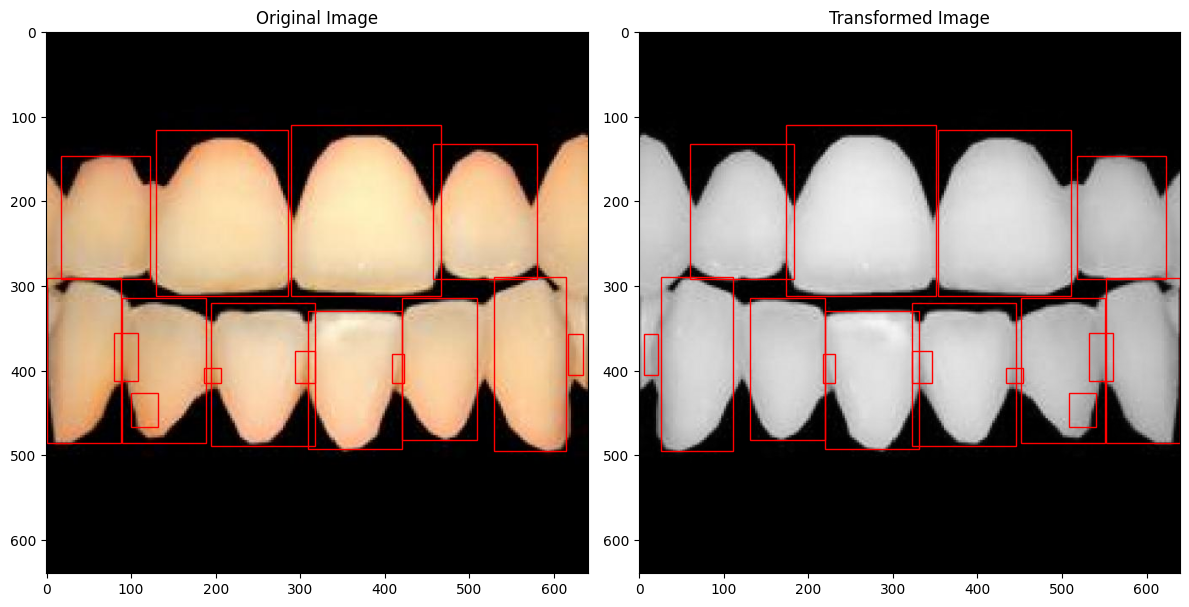

In [ ]:
visualize_dental_dataset_v4(dataset_dir, coco_data)

In [ ]:
# Define the training loop

def train_model(model, opt, num_epochs = 20, scheduler = False):
    train_losses = []  # to store training losses
    val_losses = []    # to store validation losses

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for images, targets in train_loader:
            images = [image.float().to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimization
            opt.zero_grad()
            losses.backward()
            opt.step()

            epoch_train_loss += losses.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase (model kept in train mode but without gradient caclulations for inference)
        model.train()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [image.float().to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                epoch_val_loss += losses.item()

        # Calculate average validation loss per epoch
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} => "
              f"Train loss: {avg_train_loss:.4f}, "
              f"Val_loss: {avg_val_loss:.4f}")

        if scheduler:
            scheduler.step()

    print("Training completed!")

    return train_losses, val_losses


# Model 1

#### Split and Prepare Training/Validation/Testing sets

In [ ]:
# Split dataset: Define the split ratio (85% Train, 5% Validation, 10% test)
total_size = len(full_dataset)
print(total_size)
train_size = int(0.85 * total_size)
val_size = int(0.05 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])


# Initialize datasets
train_dataset = DentalCavityDatasetV4(dataset_dir, coco_data, transforms=lambda img, tgt: transform_V1((img, tgt), True), indices=train_subset.indices)
val_dataset = DentalCavityDatasetV4(dataset_dir, coco_data, transforms=lambda img, tgt: transform_V1((img, tgt), False), indices=val_subset.indices)
test_dataset = DentalCavityDatasetV4(dataset_dir, coco_data, transforms=lambda img, tgt: transform_V1((img, tgt), False), indices=test_subset.indices)


print("Number of samples in train_dataset:", len(train_dataset))
print("Number of samples in val_dataset:", len(val_dataset))
print("Number of samples in test_dataset:", len(test_dataset))

def collate_fn(batch):
    images, targets = zip(*batch)

    # Filter out any images that still don't have bounding boxes
    images, targets = zip(*[(image, target) for image, target in zip(images, targets) if target["boxes"].numel() > 0])
    return images, targets


# Initialize data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Check the first batch to ensure there are no empty bounding boxes
for images, targets in train_loader:
    print("Number of images:", len(images))
    print("Boxes:", [target["boxes"].shape for target in targets])
    break



1040
Number of samples in train_dataset: 884
Number of samples in val_dataset: 52
Number of samples in test_dataset: 104
Number of images: 16
Boxes: [torch.Size([4, 4]), torch.Size([15, 4]), torch.Size([3, 4]), torch.Size([2, 4]), torch.Size([16, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([14, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([4, 4]), torch.Size([1, 4]), torch.Size([1, 4])]


In [ ]:
# Load a pre-trained ResNet-50 model and remove the fully connected layers at the end
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:05<00:00, 30.8MB/s]


In [ ]:
num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#define scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

## Training

In [ ]:
# Execute training
train_losses, val_losses = train_model(model, optimizer, 20, False)

Epoch 1/20 => Train loss: 0.5465, Val_loss: 0.3416
Epoch 2/20 => Train loss: 0.4040, Val_loss: 0.3162
Epoch 3/20 => Train loss: 0.3783, Val_loss: 0.2985
Epoch 4/20 => Train loss: 0.3590, Val_loss: 0.3104
Epoch 5/20 => Train loss: 0.3440, Val_loss: 0.2934
Epoch 6/20 => Train loss: 0.3256, Val_loss: 0.2730
Epoch 7/20 => Train loss: 0.3101, Val_loss: 0.2812
Epoch 8/20 => Train loss: 0.2969, Val_loss: 0.2727
Epoch 9/20 => Train loss: 0.2898, Val_loss: 0.2487
Epoch 10/20 => Train loss: 0.2767, Val_loss: 0.2492
Epoch 11/20 => Train loss: 0.2708, Val_loss: 0.2351
Epoch 12/20 => Train loss: 0.2597, Val_loss: 0.2181
Epoch 13/20 => Train loss: 0.2493, Val_loss: 0.2225
Epoch 14/20 => Train loss: 0.2445, Val_loss: 0.2178
Epoch 15/20 => Train loss: 0.2400, Val_loss: 0.2056
Epoch 16/20 => Train loss: 0.2257, Val_loss: 0.2001
Epoch 17/20 => Train loss: 0.2270, Val_loss: 0.1982
Epoch 18/20 => Train loss: 0.2187, Val_loss: 0.1999
Epoch 19/20 => Train loss: 0.2107, Val_loss: 0.1839
Epoch 20/20 => Train 

#### Visualize Learning Curves

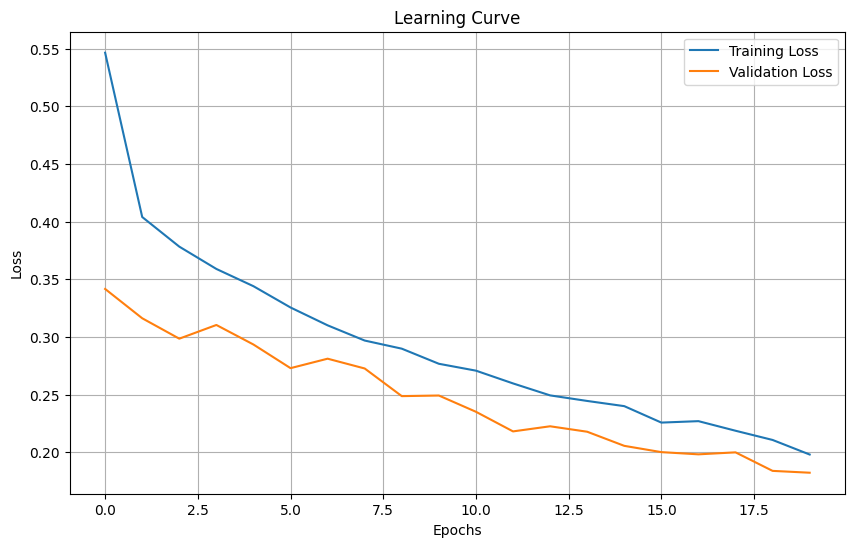

In [ ]:
# Plot learning curve (Model 1)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save entire model and state_dict (state_dict allows training to resume from the last epoch)
torch.save(model,'/content/drive/MyDrive/AAI_541_Capstone/model1_1.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/AAI_541_Capstone/model1_1_dict.pt')

# Model 2

#### Prepare Dataset using transform_V2 (full color, no grayscale)

In [ ]:
# Split dataset: Define the split ratio (85% Train, 5% Validation, 10% test)
total_size = len(full_dataset)
print(total_size)
train_size = int(0.85 * total_size)
val_size = int(0.05 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])


# Initialize datasets
train_dataset = DentalCavityDatasetV4(dataset_dir, coco_data, transforms=lambda img, tgt: transform_V2((img, tgt), True), indices=train_subset.indices)
val_dataset = DentalCavityDatasetV4(dataset_dir, coco_data, transforms=lambda img, tgt: transform_V2((img, tgt), False), indices=val_subset.indices)
test_dataset = DentalCavityDatasetV4(dataset_dir, coco_data, transforms=lambda img, tgt: transform_V2((img, tgt), False), indices=test_subset.indices)


print("Number of samples in train_dataset:", len(train_dataset))
print("Number of samples in val_dataset:", len(val_dataset))
print("Number of samples in test_dataset:", len(test_dataset))

def collate_fn(batch):
    images, targets = zip(*batch)

    # Filter out any images that still don't have bounding boxes
    images, targets = zip(*[(image, target) for image, target in zip(images, targets) if target["boxes"].numel() > 0])
    return images, targets


# Initialize data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Check the first batch to ensure there are no empty bounding boxes
for images, targets in train_loader:
    print("Number of images:", len(images))
    print("Boxes:", [target["boxes"].shape for target in targets])
    break

1040
Number of samples in train_dataset: 884
Number of samples in val_dataset: 52
Number of samples in test_dataset: 104
Number of images: 16
Boxes: [torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([13, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([12, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([2, 4]), torch.Size([1, 4]), torch.Size([1, 4]), torch.Size([1, 4])]


### Visualize second version of transforms (augmentations)

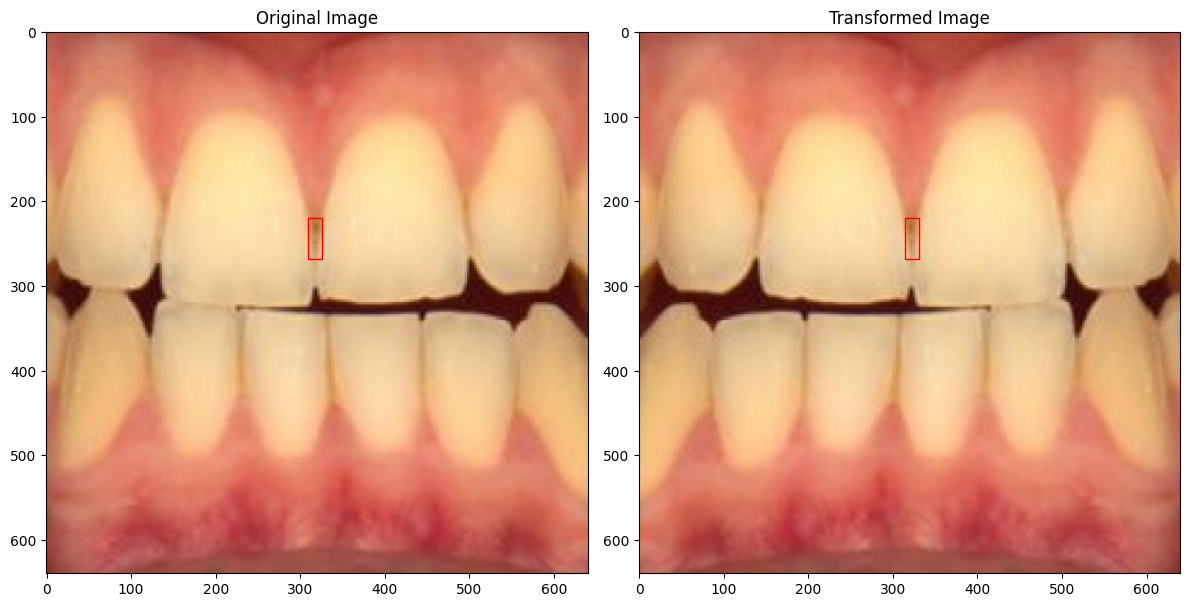

In [ ]:
visualize_dental_dataset_v4(dataset_dir, coco_data) # Remember to change transformer to transform_V2 in visualize function

### Reinstantiate Model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#define scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

## Training

In [ ]:
train_losses, val_losses = train_model(model, optimizer, 20, False)

Epoch 1/20 => Train loss: 0.5569, Val_loss: 0.3937
Epoch 2/20 => Train loss: 0.3901, Val_loss: 0.3555
Epoch 3/20 => Train loss: 0.3603, Val_loss: 0.3102
Epoch 4/20 => Train loss: 0.3432, Val_loss: 0.3063
Epoch 5/20 => Train loss: 0.3276, Val_loss: 0.2968
Epoch 6/20 => Train loss: 0.3173, Val_loss: 0.2771
Epoch 7/20 => Train loss: 0.3095, Val_loss: 0.2834
Epoch 8/20 => Train loss: 0.3011, Val_loss: 0.2804
Epoch 9/20 => Train loss: 0.2837, Val_loss: 0.2759
Epoch 10/20 => Train loss: 0.2777, Val_loss: 0.2571
Epoch 11/20 => Train loss: 0.2652, Val_loss: 0.2604
Epoch 12/20 => Train loss: 0.2558, Val_loss: 0.2458
Epoch 13/20 => Train loss: 0.2475, Val_loss: 0.2526
Epoch 14/20 => Train loss: 0.2438, Val_loss: 0.2458
Epoch 15/20 => Train loss: 0.2356, Val_loss: 0.2291
Epoch 16/20 => Train loss: 0.2234, Val_loss: 0.2314
Epoch 17/20 => Train loss: 0.2217, Val_loss: 0.2300
Epoch 18/20 => Train loss: 0.2123, Val_loss: 0.2337
Epoch 19/20 => Train loss: 0.2092, Val_loss: 0.2081
Epoch 20/20 => Train 

In [ ]:
# Save entire model and state_dict (state_dict allows training to resume from the last epoch)
torch.save(model,'/content/drive/MyDrive/AAI_541_Capstone/model2_1.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/AAI_541_Capstone/model2_1_dict.pt')

In [ ]:
# Train again now with Learning Rate at 0.008

optimizer2 = torch.optim.SGD(params, lr=0.008, momentum=0.9, weight_decay=0.0005)
train_losses, val_losses = train_model(model, optimizer2, 20, False)

Epoch 1/20 => Train loss: 0.5356, Val_loss: 0.3801
Epoch 2/20 => Train loss: 0.3848, Val_loss: 0.3435
Epoch 3/20 => Train loss: 0.3560, Val_loss: 0.3253
Epoch 4/20 => Train loss: 0.3469, Val_loss: 0.3289
Epoch 5/20 => Train loss: 0.3306, Val_loss: 0.2963
Epoch 6/20 => Train loss: 0.3174, Val_loss: 0.2989
Epoch 7/20 => Train loss: 0.3033, Val_loss: 0.2933
Epoch 8/20 => Train loss: 0.2947, Val_loss: 0.2982
Epoch 9/20 => Train loss: 0.2863, Val_loss: 0.2808
Epoch 10/20 => Train loss: 0.2709, Val_loss: 0.2777
Epoch 11/20 => Train loss: 0.2650, Val_loss: 0.2682
Epoch 12/20 => Train loss: 0.2550, Val_loss: 0.2809
Epoch 13/20 => Train loss: 0.2511, Val_loss: 0.2274
Epoch 14/20 => Train loss: 0.2373, Val_loss: 0.2253
Epoch 15/20 => Train loss: 0.2319, Val_loss: 0.2365
Epoch 16/20 => Train loss: 0.2245, Val_loss: 0.2415
Epoch 17/20 => Train loss: 0.2196, Val_loss: 0.2243
Epoch 18/20 => Train loss: 0.2103, Val_loss: 0.2016
Epoch 19/20 => Train loss: 0.1999, Val_loss: 0.1985
Epoch 20/20 => Train 

In [ ]:
# Save entire model and state_dict (state_dict allows training to resume from the last epoch)
torch.save(model,'/content/drive/MyDrive/AAI_541_Capstone/model2_2.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/AAI_541_Capstone/model2_2_dict.pt')

### Visualize Learning Curves

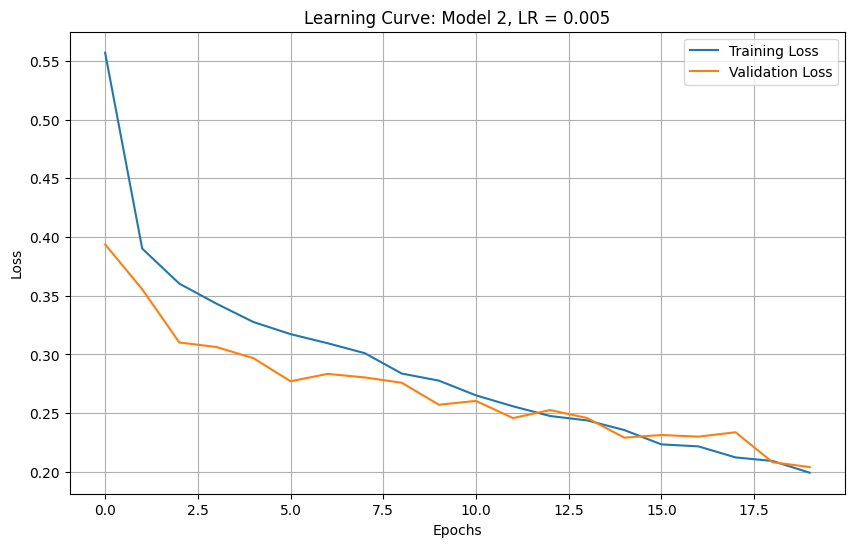

In [ ]:
# Plot learning curve (Model 2 w/ LR = .005)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Model 2, LR = 0.005')
plt.legend()
plt.grid(True)
plt.show()

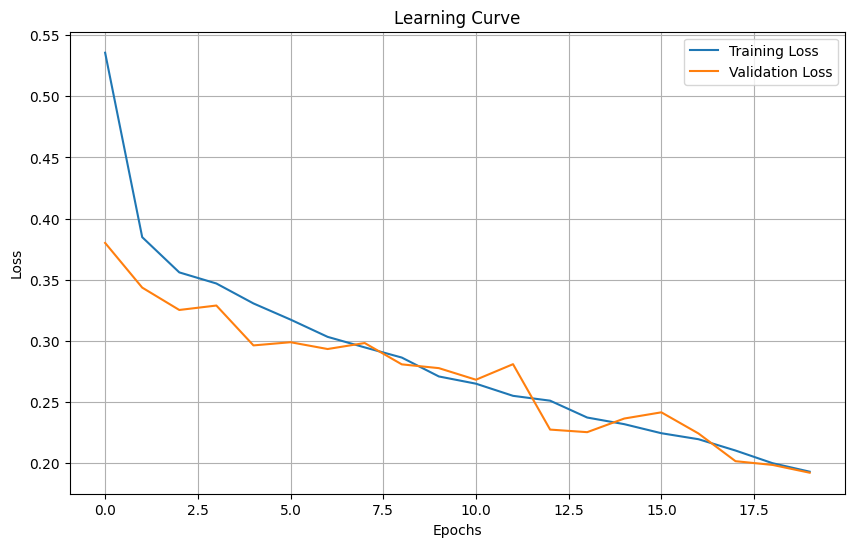

In [ ]:
# Plot learning curve (Model 2 w/ LR = .008))
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Functions

In [ ]:
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support


# Define evaluation functions to calculate precision, recall, F1, and mean average precision
num_classes = 3

# Calculate intersection over union of two bounding boxes
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    # Calculate intersection area
    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)
    inter_area = max(inter_x2 - inter_x1, 0) * max(inter_y2 - inter_y1, 0)

    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou

def evaluate_model(model, data_loader, iou_threshold=0.5):
    model.eval()

    all_true_positives = 0
    all_false_positives = 0
    all_false_negatives = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.float().to(device) for image in images]
            predictions = model(images)

            for idx, prediction in enumerate(predictions):
                pred_boxes = prediction['boxes'].cpu().numpy()
                gt_boxes = targets[idx]['boxes'].cpu().numpy()

                true_positives = 0
                for pred_box in pred_boxes:
                    ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
                    max_iou = max(ious) if ious else 0

                    if max_iou > iou_threshold:
                        true_positives += 1

                false_positives = len(pred_boxes) - true_positives
                false_negatives = len(gt_boxes) - true_positives

                all_true_positives += true_positives
                all_false_positives += false_positives
                all_false_negatives += false_negatives

    precision = all_true_positives / (all_true_positives + all_false_positives) if all_true_positives + all_false_positives != 0 else 0
    recall = all_true_positives / (all_true_positives + all_false_negatives) if all_true_positives + all_false_negatives != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    return precision, recall, f1



def evaluate_model_per_label(model, data_loader, iou_threshold=0.5, num_classes = num_classes):
    model.eval()

    all_true_positives = [0] * num_classes
    all_false_positives = [0] * num_classes
    all_false_negatives = [0] * num_classes

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.float().to(device) for image in images]
            predictions = model(images)

            for idx, prediction in enumerate(predictions):
                pred_boxes = prediction['boxes'].cpu().numpy()
                pred_labels = prediction['labels'].cpu().numpy()
                gt_boxes = targets[idx]['boxes'].cpu().numpy()
                gt_labels = targets[idx]['labels'].cpu().numpy()

                for label in range(num_classes):
                    true_positives = 0

                    label_pred_boxes = pred_boxes[pred_labels == label]
                    label_gt_boxes = gt_boxes[gt_labels == label]

                    matched_gt_indices = []

                    for pred_box in label_pred_boxes:
                        ious = [calculate_iou(pred_box, gt_box) for gt_box in label_gt_boxes]
                        if ious:
                            max_iou_index = np.argmax(ious)
                            if ious[max_iou_index] > iou_threshold and max_iou_index not in matched_gt_indices:
                                true_positives += 1
                                matched_gt_indices.append(max_iou_index)

                    false_positives = len(label_pred_boxes) - true_positives
                    false_negatives = len(label_gt_boxes) - true_positives

                    all_true_positives[label] += true_positives
                    all_false_positives[label] += false_positives
                    all_false_negatives[label] += false_negatives

    precisions = []
    recalls = []
    f1_scores = []

    for label in range(num_classes):
        precision = all_true_positives[label] / (all_true_positives[label] + all_false_positives[label]) if all_true_positives[label] + all_false_positives[label] != 0 else 0
        recall = all_true_positives[label] / (all_true_positives[label] + all_false_negatives[label]) if all_true_positives[label] + all_false_negatives[label] != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    return precisions, recalls, f1_scores

def compute_ap(recall, precision):
    #Compute the average precision, given the recall and precision curves.
            # Code adapted from https://github.com/rbgirshick/py-faster-rcnn.

    # First append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # Compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # To calculate area under PR curve, look for points where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # sum (Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def compute_mAP(model, data_loader, num_classes=num_classes, iou_threshold=0.5):
    model.eval()

    all_detections = [[] for _ in range(num_classes)]
    all_annotations = [[] for _ in range(num_classes)]

    # run eval loop without gradient calculations
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.float().to(device) for image in images]
            predictions = model(images)

            for idx, prediction in enumerate(predictions):
                pred_boxes = prediction['boxes'].cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                pred_labels = prediction['labels'].cpu().numpy()
                gt_boxes = targets[idx]['boxes'].cpu().numpy()
                gt_labels = targets[idx]['labels'].cpu().numpy()

                for label in range(num_classes):
                    all_annotations[label].extend(gt_boxes[gt_labels == label])
                    detected = pred_boxes[(pred_labels == label) & (pred_scores > 0.05)]
                    all_detections[label].extend(detected)

    average_precisions = {}

    for label in range(num_classes):
        detections = all_detections[label]
        annotations = all_annotations[label]

        true_positives = np.zeros(len(detections))
        false_positives = np.zeros(len(detections))
        num_annotations = len(annotations)

        detected_annotations = []

        for d_idx, detection in enumerate(detections):
            ious = np.array([calculate_iou(detection, gt_annotation) for gt_annotation in annotations])
            assigned_annotation = np.argmax(ious)
            max_iou = ious[assigned_annotation]

            if max_iou >= iou_threshold and assigned_annotation not in detected_annotations:
                true_positives[d_idx] = 1
                detected_annotations.append(assigned_annotation)
            else:
                false_positives[d_idx] = 1

        # Compute precision and recall
        accumulated_false_positives = np.cumsum(false_positives)
        accumulated_true_positives = np.cumsum(true_positives)
        recall = accumulated_true_positives / float(num_annotations)
        precision = accumulated_true_positives / (accumulated_true_positives + accumulated_false_positives)

        # Compute average precision
        average_precision = compute_ap(recall, precision)
        average_precisions[label] = average_precision

    mAP = np.mean(list(average_precisions.values()))
    return mAP, average_precisions


def visualize_predictions(image, predictions, ground_truth):

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Draw predicted bounding boxes
    for box in predictions['boxes']:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 10, "Predicted", color='red', verticalalignment='top')

    # Draw ground truth bounding boxes
    for box in ground_truth['boxes']:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 10, "Ground Truth", color='green', verticalalignment='top')

    plt.show()





#Evaluation Results

##Model 1

In [ ]:
# Load Model
model = torch.load('/content/drive/MyDrive/AAI_541_Capstone/model1_1.pt')

In [ ]:
# Calculate and print the metrics per label
label_metrics = evaluate_model_per_label(model, test_loader)
label_names = ["background", "cavity", "non_cavity"]

for label, precision, recall, f1 in zip(label_names, *label_metrics):
    print(f"Label: {label}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)

Label: background
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
------------------------------
Label: cavity
Precision: 0.4350
Recall: 0.9609
F1 Score: 0.5989
------------------------------
Label: non_cavity
Precision: 0.5040
Recall: 0.9960
F1 Score: 0.6693
------------------------------


In [ ]:
# Get mean average precision using IOU threshold of 0.5
mAP, average_precisions = compute_mAP(model, test_loader, iou_threshold = 0.5)
print(f"mAP: {mAP:.4f}")
for label, ap in average_precisions.items():
    print(f"AP for class {label}: {ap:.4f}")

mAP: 0.3644
AP for class 0: 0.0000
AP for class 1: 0.4714
AP for class 2: 0.6218


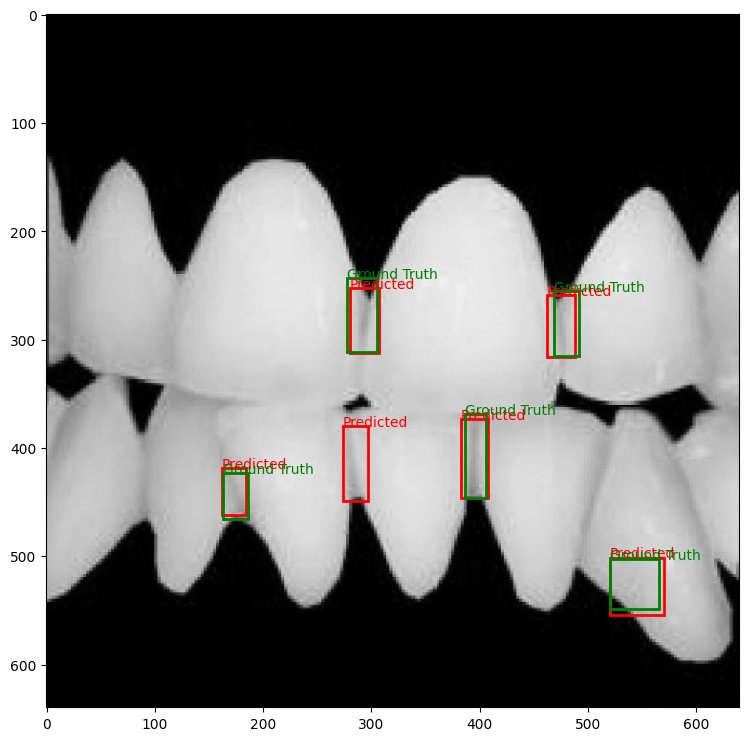

In [ ]:
# Visualize predictions for model 1

# Load batch of data
sample_data = next(iter(test_loader))  # Using the test loader as an example
images, gt_data = sample_data

# Predict bounding boxes for a sample image
sample_image = images[0].to(device).unsqueeze(0).float()  # Get image, add batch dimension, and convert to float

image_pil = transforms.ToPILImage()(images[0].cpu())
model.eval()
with torch.no_grad():
    predictions = model(sample_image)

# Determine the class label for 'cavity'
cavity_label = 1  # Adjust this based on your dataset's class encoding

# Filter the predictions based on this class label
filtered_pred_boxes = []
for idx, label in enumerate(predictions[0]['labels']):
    if label == cavity_label and predictions[0]['scores'][idx] > 0.5:  # Using a score threshold of 0.5 as an example
        filtered_pred_boxes.append(predictions[0]['boxes'][idx])

# Filter ground truth boxes for 'cavity'
filtered_gt_boxes = []
for idx, label in enumerate(gt_data[0]['labels']):
    if label == cavity_label:
        filtered_gt_boxes.append(gt_data[0]['boxes'][idx])

# Check if there are any predicted boxes for 'cavity'
if len(filtered_pred_boxes) == 0:
    print("No predictions for 'cavity' above the threshold.")
    visualize_predictions(image_pil, {'boxes': []}, {'boxes': torch.stack(filtered_gt_boxes).cpu()})
else:
    visualize_predictions(image_pil, {'boxes': torch.stack(filtered_pred_boxes).cpu()}, {'boxes': torch.stack(filtered_gt_boxes).cpu()})




## Model 2_1

In [ ]:
# Load Model
model = torch.load('/content/drive/MyDrive/AAI_541_Capstone/model2_1.pt')

In [ ]:
# Calculate and print the metrics per label
label_metrics = evaluate_model_per_label(model, test_loader)
label_names = ["background", "cavity", "non_cavity"]

for label, precision, recall, f1 in zip(label_names, *label_metrics):
    print(f"Label: {label}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)

Label: background
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
------------------------------
Label: cavity
Precision: 0.4481
Recall: 0.9565
F1 Score: 0.6103
------------------------------
Label: non_cavity
Precision: 0.5354
Recall: 0.9885
F1 Score: 0.6946
------------------------------


In [ ]:
# Get mean average precision using IOU threshold of 0.5
mAP, average_precisions = compute_mAP(model, test_loader, iou_threshold = 0.5)
print(f"mAP: {mAP:.4f}")
for label, ap in average_precisions.items():
    print(f"AP for class {label}: {ap:.4f}")

mAP: 0.3893
AP for class 0: 0.0000
AP for class 1: 0.5477
AP for class 2: 0.6201


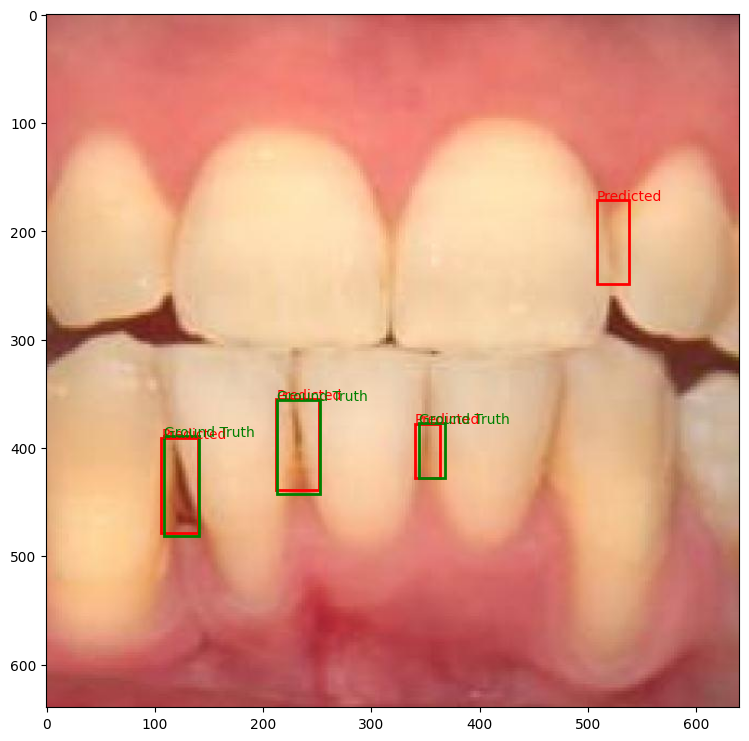

In [ ]:
# Visualize predictions for model 1

# Load batch of data
sample_data = next(iter(test_loader))  # Using the test loader as an example
images, gt_data = sample_data

# Predict bounding boxes for sample image
sample_image = images[0].to(device).unsqueeze(0).float()  # Get image, add batch dimension, and convert to float

image_pil = transforms.ToPILImage()(images[0].cpu())
model.eval()
with torch.no_grad():
    predictions = model(sample_image)

# Determine the class label for 'cavity'
cavity_label = 1

# Filter the predictions based on this class label
filtered_pred_boxes = []
for idx, label in enumerate(predictions[0]['labels']):
    if label == cavity_label and predictions[0]['scores'][idx] > 0.5:  # IOU score threshold of 0.5
        filtered_pred_boxes.append(predictions[0]['boxes'][idx])

# Filter the ground truth boxes for 'cavity'
filtered_gt_boxes = []
for idx, label in enumerate(gt_data[0]['labels']):
    if label == cavity_label:
        filtered_gt_boxes.append(gt_data[0]['boxes'][idx])

# Check if there are any predicted boxes for 'cavity'
if len(filtered_pred_boxes) == 0:
    print("No predictions for 'cavity' above the threshold.")
    visualize_predictions(image_pil, {'boxes': []}, {'boxes': torch.stack(filtered_gt_boxes).cpu()})
else:
    visualize_predictions(image_pil, {'boxes': torch.stack(filtered_pred_boxes).cpu()}, {'boxes': torch.stack(filtered_gt_boxes).cpu()})


## Model 2_2

In [ ]:
# Load Model
model = torch.load('/content/drive/MyDrive/AAI_541_Capstone/model2_2.pt')

In [ ]:
# Calculate and print the metrics per label
label_metrics = evaluate_model_per_label(model, test_loader)
label_names = ["background", "cavity", "non_cavity"]

for label, precision, recall, f1 in zip(label_names, *label_metrics):
    print(f"Label: {label}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)

Label: background
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
------------------------------
Label: cavity
Precision: 0.5505
Recall: 0.9478
F1 Score: 0.6965
------------------------------
Label: non_cavity
Precision: 0.5743
Recall: 0.9808
F1 Score: 0.7244
------------------------------


In [ ]:
mAP, average_precisions = compute_mAP(model, test_loader, iou_threshold = 0.5)
print(f"mAP: {mAP:.4f}")
for label, ap in average_precisions.items():
    print(f"AP for class {label}: {ap:.4f}")

mAP: 0.3846
AP for class 0: 0.0000
AP for class 1: 0.5610
AP for class 2: 0.5926


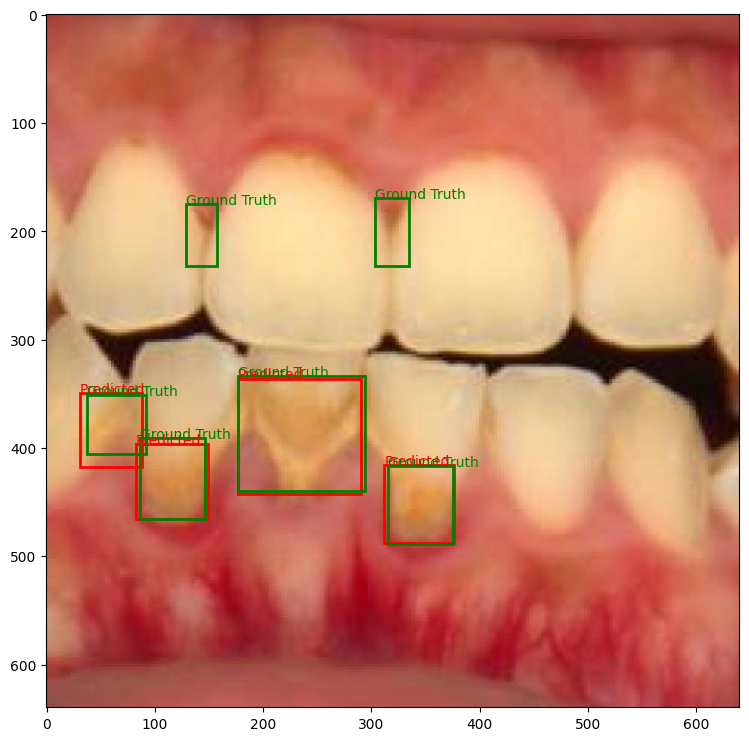

In [ ]:
# Visualize predictions for model 1

# Load batch of data
sample_data = next(iter(test_loader))  # Using the test loader as an example
images, gt_data = sample_data

# Predict bounding boxes for sample image
sample_image = images[0].to(device).unsqueeze(0).float()  # Get image, add batch dimension, and convert to float

image_pil = transforms.ToPILImage()(images[0].cpu())
model.eval()
with torch.no_grad():
    predictions = model(sample_image)

# Determine the class label for 'cavity'
cavity_label = 1  # Adjust this based on your dataset's class encoding

# Filter the predictions based on this class label
filtered_pred_boxes = []
for idx, label in enumerate(predictions[0]['labels']):
    if label == cavity_label and predictions[0]['scores'][idx] > 0.5:  # Using IOU threshold of 0.5
        filtered_pred_boxes.append(predictions[0]['boxes'][idx])

# Filter the ground truth boxes for 'cavity'
filtered_gt_boxes = []
for idx, label in enumerate(gt_data[0]['labels']):
    if label == cavity_label:
        filtered_gt_boxes.append(gt_data[0]['boxes'][idx])

# Check if there are any predicted boxes for 'cavity'
if len(filtered_pred_boxes) == 0:
    print("No predictions for 'cavity' above the threshold.")
    visualize_predictions(image_pil, {'boxes': []}, {'boxes': torch.stack(filtered_gt_boxes).cpu()})
else:
    visualize_predictions(image_pil, {'boxes': torch.stack(filtered_pred_boxes).cpu()}, {'boxes': torch.stack(filtered_gt_boxes).cpu()})
